# Eigenface Decomposition
#### MATH 469 Final Project

Preston Dunton

6 May, 2021

<img src="./images/banner.PNG" alt="faces" width="100%" height="100%" align="center">

# Introduction (Abstract)

Eigenface decomposition is the application of Principal Component Analysis (PCA) on images that contain faces in them.  This decomposition allows implementers to achieve data reduction in images by calculating the vectors in high dimensional space that represent the largest variation in images.  These vectors are called eigenfaces, and are the principal components of a dataset of face images.  The corresponding eigenvalues represent the variance in image data each eigenface explains.  Applying this to data reduction, we observe a 2.618 : 1 data reduction, but also that modern data reduction techniques are more efficient.  Furthermore, we observe that by keeping the first 1589 eigenvectors in ${\rm I\!R}^{4096}$, we can retain 99.9% of variation in images.  Finally, a discussion of this technique applied to facial recognition and machine learning is presented.

# Eigenface Decomposition

## Principal Component Analysis

The process of creating eigenfaces is a the use of a statistical method called **Principal Component Analysis** (PCA) on a dataset of face images.  Each observation in the dataset is a different face, and each variable is the value that a given pixel takes on.  For color images, each pixel has 3 values (red, green, and blue), but for greyscale images, there is only 1 value.  In this project, greyscale images are used.  

Principal Component Analysis is the process of taking data, and writing it in a more efficient representation.  Let each image be $N\times N$ pixels.  This means that we can flatten the image's pixels to be an $N^2 \times 1$ vector (a row vector here). We can think of our data as a collection of points $\mathbf x_i$ ($i=1...M$) in the $N^2$ dimensional space ${\rm I\!R}^{N^2}$. Let $X$ be our dataset with $M$ observations.  We can write $X$ as an $N^2 \times M$ matrix **[[1]](#sources)**.

<br>

$$\textbf{Flattening Images}\;\;\;\;\;\;\mathbf x_i = \begin{bmatrix}x_{11} & ... & x_{1N} \\ ... & ... & ... \\x_{N1} & ... & x_{NN} \end{bmatrix} \longrightarrow \begin{bmatrix}x_{11} \\ x_{12} \\ x_{13} \\ ... \\ x_{NN}\end{bmatrix}$$

<br>

$$\textbf{Data Matrix}\;\;\;\;\;\;\underset{(N^2 \times M)}{X}=\begin{bmatrix}\mathbf x_{1} & \mathbf x_{2} & \mathbf x_{3} & ... & \mathbf x_{M}\end{bmatrix}=\begin{bmatrix}x_{11} & x_{12} & ... & x_{1M}\\ x_{21} & x_{22} & ... & x_{2M}\\  ... & ... & ... & ... \\ x_{N^21} & x_{N^22} & ... & x_{N^2M}\\\end{bmatrix}$$

<br>

PCA considers the **covariance** matrix of $X$.  The covariance matrix is a multi-dimensional generalization of the variance statistic, and describes how data (vectors) are spread out in higher dimensional space.  In a dataset with $N^2$ dimensions, the covariance matrix $S$ will be of size $N^2 \times N^2$.  $S_{ij}$ represents the covariance between the $i^{th}$ and $j^{th}$ variables.  When $i=j$, $S_{ij}$ represents the variance of the $i^{th}$ variable.  To calculate $S$, we center our data $X$ by subtracting its row-wise mean vector $\mu$, multiply by the transpose, and divide by the corresponding degrees of freedom ($M - 1$) **[[1]](#sources)**.

<br>

$$\textbf{Mean Vector}\;\;\;\;\;\;\underset{(N^2 \times 1)}{\mu} = \frac{1}{M} \; \underset{(N^2 \times M)}{X} \underset{(M \times 1)}{\mathbf 1} = \frac{1}{M} \; \begin{bmatrix}x_{11} & x_{12} & ... & x_{1M}\\ x_{21} & x_{22} & ... & x_{2M}\\  ... & ... & ... & ... \\ x_{N^21} & x_{N^22} & ... & x_{N^2M}\\\end{bmatrix} \begin{bmatrix}1 \\ 1 \\ ... \\ 1\end{bmatrix} = \begin{bmatrix}\bar{x_1} \\ \bar{x_2} \\ ... \\ \bar{x}_{N^2}\end{bmatrix}$$

<br>

$$\textbf{Mean Centered Data}\;\;\;\;\;\;\underset{(N^2 \times M)}{\bar X} = \underset{(N^2 \times M)}{X} - \underset{(N^2 \times M)}{\begin{bmatrix}\mu & ... & \mu \end{bmatrix}}$$

<br>

$$\textbf{Covariance Matrix}\;\;\;\;\;\;\underset{(N^2 \times N^2)}{S}=\frac{1}{M-1} \; \underset{(N^2 \times M)}{\bar{X}} \underset{(M \times N^2)}{\bar{X}^T}$$

<br>

Because the covariance matrix is square, we can interpret it as an operator on ${\rm I\!R}^{N^2}$.  In other words, $S \in \mathcal{L}({\rm I\!R}^{N^2})$.  Consider the eigenvectors, $e_1, ... , e_{N^2}$, and eigenvalues, $\lambda_1, ... , \lambda_{N^2}$, of $S$. Because $S$ is a covariance matrix, it is guaranteed to be positive, meaning that its eigenvalues are real and positive **[[2]](#sources)**.  This corresponds to stretching space by positive scalars.  These eigenvectors also form an orthonormal basis of ${\rm I\!R}^{N^2}$, which means that their inner products are all 0, and there is no correlation between the eigenvectors **[[3]](#sources)**.  Because there is no correlation between the eigenvectors, each eigenvector represents unique information in the space, and therefore is the optimal basis for representing our data in ${\rm I\!R}^{N^2}$.

<br>

$$\textbf{Ordered, Positive Eigenvalues}\;\;\;\;\;\;\lambda_1 \geq ... \geq \lambda_{N^2} \geq 0$$

<br>

$$\textbf{Orthonormal Eigenvectors}\;\;\;\;\;\;\langle\,e_i,e_j\rangle = \begin{cases} 
      0 & \text{for} \;\;i \neq j \\
      1 & \text{for} \;\;i = j 
   \end{cases}$$

<br>

We call $e_1, ... , e_{N^2}$ the **principal components** of $X$.  The eigenvalues, $\lambda_1, ... , \lambda_{N^2}$ (with multiplicity), are the **variances** of $X$ that each corresponding principal component explains **[[2]](#sources)**.  When we transform space by the operator $S$, we are essentially stretching the principal components by the variances each principal component explains. 

By ordering the eigenvectors in decreasing order of their eigenvalues and selecting the first $k$ eigenvectors, we can create a basis for a subspace of ${\rm I\!R}^{N^2}$ that maximally represents the variance of $X$ **[[2]](#sources)**.  In this application, if we plot the eigenvectors as images, they resemble faces.  Therefore, they are also referred to as **eigenfaces**.

By projecting the observations of $X$ onto the subspace spanned by our basis $e_1, ... , e_k$, we can perform dimension reduction.  Dimension reduction is an important technique used in data compression and machine learning, which are discussed in later sections.

## Calculating Eigenfaces

The task of calculating eigenfaces is just an eigen-decomposition of $S$, which is an $N^2 \times N^2$ matrix.  However, for very large $N^2$ (large images), this task becomes computationally infeasible.  However, we can still calculate eigenvectors of $S$ by observing properties on $S$ and $X$. 

We can define S to be a product of a matrix $A$ and its transpose $A^T$.

$$\underset{(N^2 \times N^2)}{S}=\frac{1}{M-1} \; \underset{(N^2 \times M)}{\bar{X}} \underset{(M \times N^2)}{\bar{X}^T} = \underset{(N^2 \times N^2)}{AA^T} \;\;\;\text{where}\;\;\; \underset{(N^2 \times M)}{A}=\sqrt{\frac{1}{M-1}}\underset{(N^2 \times M)}{\bar{X}}$$

Consider an eigenvalue / eigenvector pair,  $(\lambda,w)$,  of $\underset{(M \times M)}{A^TA}$.

$$A^TAw=\lambda w$$

$$AA^TAw=A\lambda w$$

$$AA^TAw=\lambda Aw$$

$$\text{Let}\;\;\;\;\;Aw=v$$

$$AA^Tv=\lambda v$$

Notice, we now have calculated an eigenvalue / eigenvector pair, $(\lambda,w)$, of $S=AA^T$, which was our original goal.  By using this technique, we see that $S$ and $A^TA$ have the same eigenvalues, and their eigenvectors are related by $Av=w$ **[[4]](#sources)**.

We can compute the eigenvectors / eigenvalues of whichever matrix is smaller, and obtain $\min(N^2, M)$ eigenvectors / eigenvalues.  Because one goal is to reduce data by retaining only the first $k$ eigenvectors, we don't need to calculate all the eigenvectors available.  Furthermore, it has been shown that using this method we can obtain the largest eigenvalues of S, which will represent the largest variances **[[1]](#sources)**.


## Note

Computer scientists and statisticians use the convention of keeping data in *long form*, which has observations spread along rows and variables spread along columns.  Linear algebra, however has the opposite convention of keeping data in *wide form*, which has variables spread along rows and observations spread along columns.  Long forms and wide forms are matrix transposes of each other.  The mathematical proofs presented have the dataset in wide form, wheras the code implementation takes data in long form, and internally transposes it into wide form for calculations.

# Demonstration

## Imports and Constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from eigenfaces import Eigenfaces
from eigenfaces import plot_images
from eigenfaces import load_data

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

RANDOM_SEED = 1936

## Dataset Import

The dataset used in this project is the LFWcrop Face Dataset.  The LFWcrop is a cropped version of the Labeled Faces in the Wild dataset, which is a collection of labeled face images in both color and greyscale.  The cropped version crops the images to just contain the faces, and no background.  There are 13,233 images of 64x64 pixels each.  We flatten these 64x64 images to be 4096x1 column vectors.  This means that in our problem $N^2=4096$ and $M=13233$. Some people included in the dataset have more than one image associated with them.  There are 5749 different people included in the dataset.  On average, each person has 2.3 images associated with them. **[[5]](#sources)**.  

In [2]:
num_images = 13233 #load all images

X, y = load_data("datasets/lfwcrop_grey/faces", num_images, shuffle=True, random_state = RANDOM_SEED)

X.shape, y.shape

((13233, 4096), (13233,))

## Training

In [3]:
ef = Eigenfaces()
    
ef.fit(X)

## Eigenfaces and Reconstructed Faces

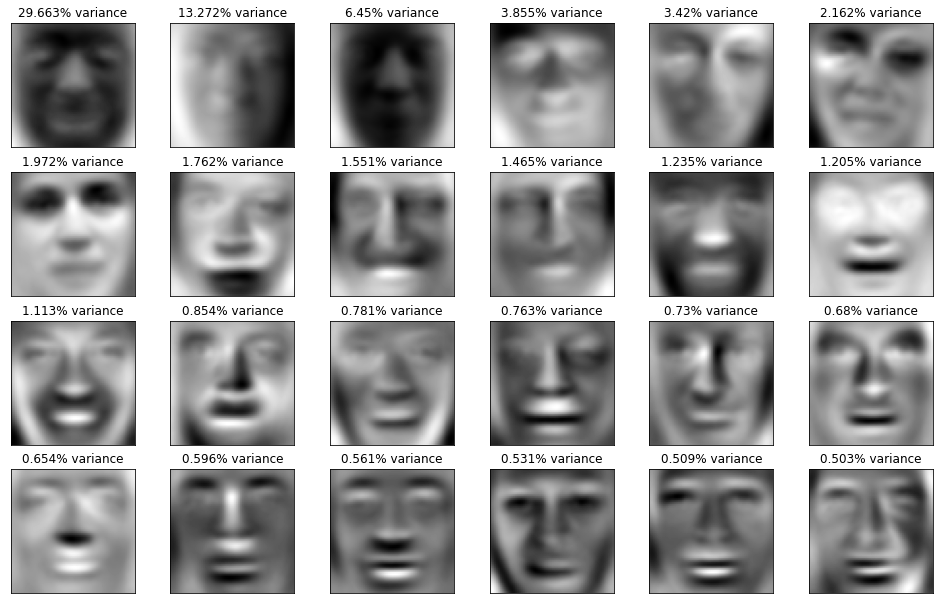

In [4]:
plot_images(ef.eigenvectors[ef.basis][0:24], 
            titles = [str(round(var*100,3)) + "% variance" for var in ef.var_props][0:24])

Plotted above is the first 24 eigenfaces calculated from the covariance matrix of all faces.  These images are the eigenvectors of the covariance matrix, sorted by their eigenvalue (variance).  Training with more face images will result in convergent eigenfaces.  For low numbers of training images, these eigenfaces are approximately noise.  We can see that each eigenface encodes unique (orthogonal) information to be used in a linear combination for a given image.  

For example, the first eigenface encodes general lighting, the second encodes horizontal lighting differences, and the third encodes background lighting.  Lighting is usually the cause of the most variation in images.  Some methods have shown that by removing the first couple of eigenfaces, we can project images onto a space that eliminates lighting variance, which is desireable for facial recognition **[[6]](#sources)**.  Other eigenfaces can encode specific features, such as glasses, sunglasses, facial hair, and more.

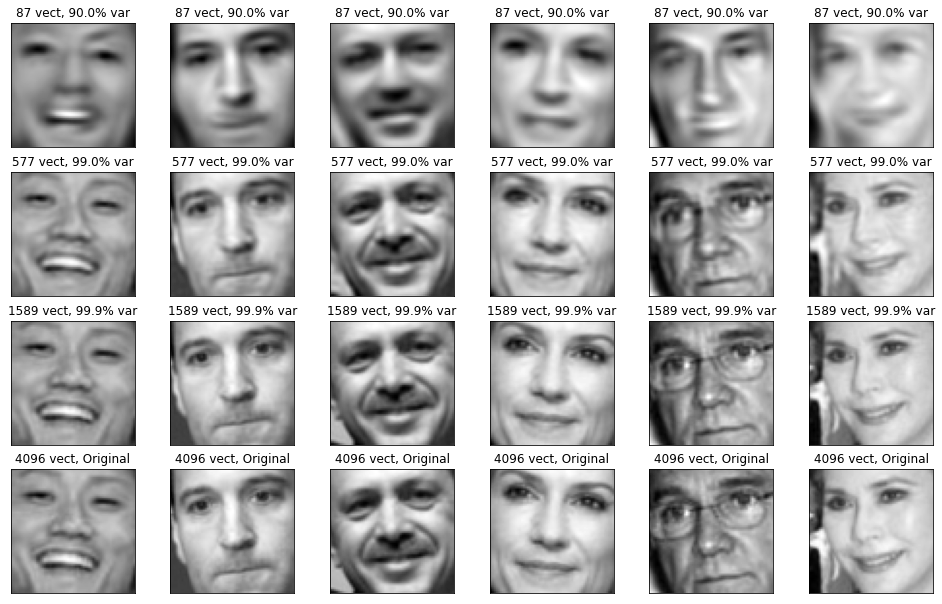

In [5]:
prop_vars = [0.9, 0.99, 0.999]
images = np.empty((0,4096))
labels = []

for prop_var in prop_vars:
    ef._set_basis(prop_var_retained = prop_var)

    images = np.concatenate((images, ef.project(X[0:6])))
    string = str(len(ef.basis)) + " vect, " + str(prop_var * 100) + "% var"
    labels = labels + ([string] * 6)

images = np.concatenate((images, X[0:6]))
labels = labels + (["4096 vect, Original"] * 6)

plot_images(images, titles = labels)

Above you can see 6 images from the dataset projected onto 3 different orthanormal bases of ${\rm I\!R}^{4096}$.  These bases (eigenfaces) were calculated using the 13,233 observations, but taking the time to compute with more is also possible.  The first orthonormal basis is chosen so that the eigenfaces saved retain 90% of the total variance of images in the dataset.  The second and third bases use the same method, but for 99% and 99.9% of the original variance.  By specifying these proportions of variance, we obtain bases for ${\rm I\!R}^{87}$, ${\rm I\!R}^{577}$, and ${\rm I\!R}^{1589}$.  We can see that the images get sharper with more eigenfaces, and by 1540 out of 4069 eigenfaces, we already have an almost indistinguishable projection.

# Data Reduction Analysis

By choosing a number of eigenvectors $k$ such that $k < N^2$, we can reduce the number of scalars we need to store for each image.  This method is not lossless, but because the eigenvectors are sorted in order of the variance they explain, we can select the eigenvectors that will retain the most variance.

Text(0.5, 1.0, 'Proportion of Image Variance')

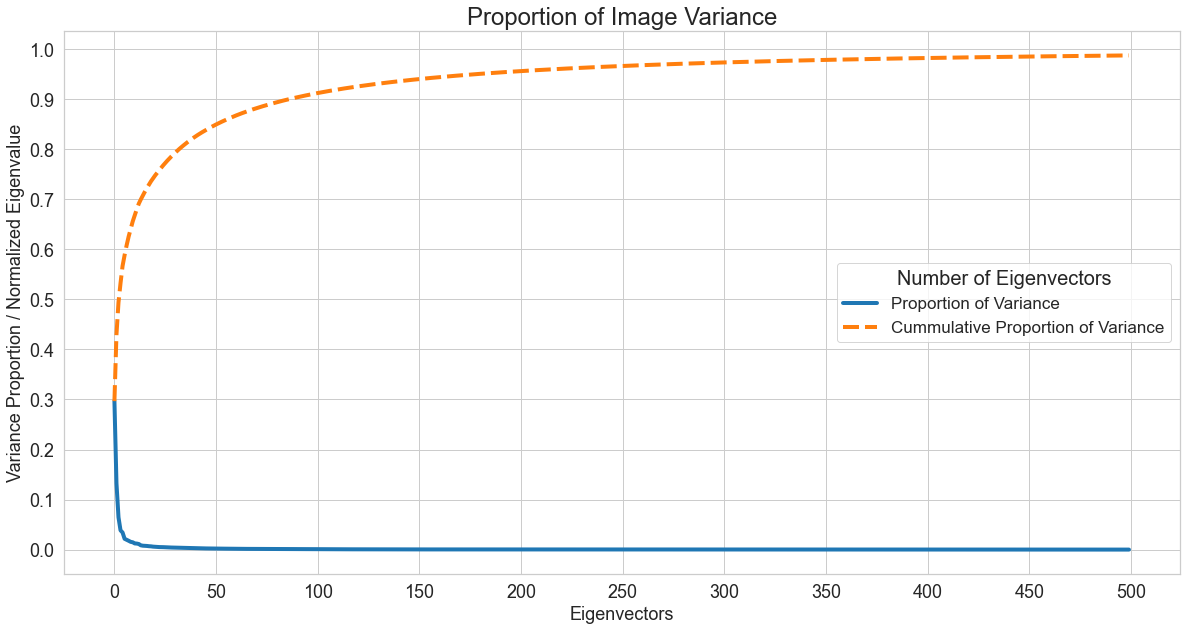

In [6]:
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")

data = pd.DataFrame({"Proportion of Variance": ef.var_props[0:500], 
                     "Cummulative Proportion of Variance": ef.cumu_var_props[0:500]}
                   )
sns.lineplot(data=data, linewidth=4, palette="tab10")

plt.xlabel("Eigenvectors", size = 18)
plt.ylabel("Variance Proportion / Normalized Eigenvalue", size = 18)
plt.xticks(range(0,550,50), fontsize=18)
plt.yticks(np.linspace(0,1,11), fontsize=18)
plt.legend(data.columns, fontsize = 17, title="Number of Eigenvectors", title_fontsize = 20)

plt.title("Proportion of Image Variance", size=24)

We can see from the plot above that the first eigenvector explains nearly 30% of the total variance in the images.  This quickly decreases, and by 50 out of the 4069 eigenvectors, the eigenvectors don't explain much variance. For higher and higher eigenvectors, the eigenfaces are usually just noise, and don't encode useful features into images.

We can also see that as we include more eigenvectors into our orthonormal basis, we are able to represent more and more variance in the images reconstructed.  By 500 eigenvectors, we are close to representing 100% of the total variance in an image.  This means that we can store each image as 500 scalars rather than 4069, resulting in a near 8:1 data reduction ratio.  This curve also allows us to specify a cummulative variance of proportion and solve for how many eigenvectors are needed.  This technique is used several times in this project via the private function `Eigenfaces()._set_basis(prop_var_retained = )`.

In [7]:
prop_vars = [0.9, 0.99, 0.999]
distances_table = pd.DataFrame()
    

for prop_var in prop_vars:
    ef._set_basis(prop_var_retained = prop_var)

    distances_to_subspace = np.linalg.norm(X - ef.project(X), axis=1)
    distances_table.insert(len(distances_table.columns), 
                           str(len(ef.basis)) + " (" + str(round(100*prop_var,3)) + "% var)", distances_to_subspace, True)

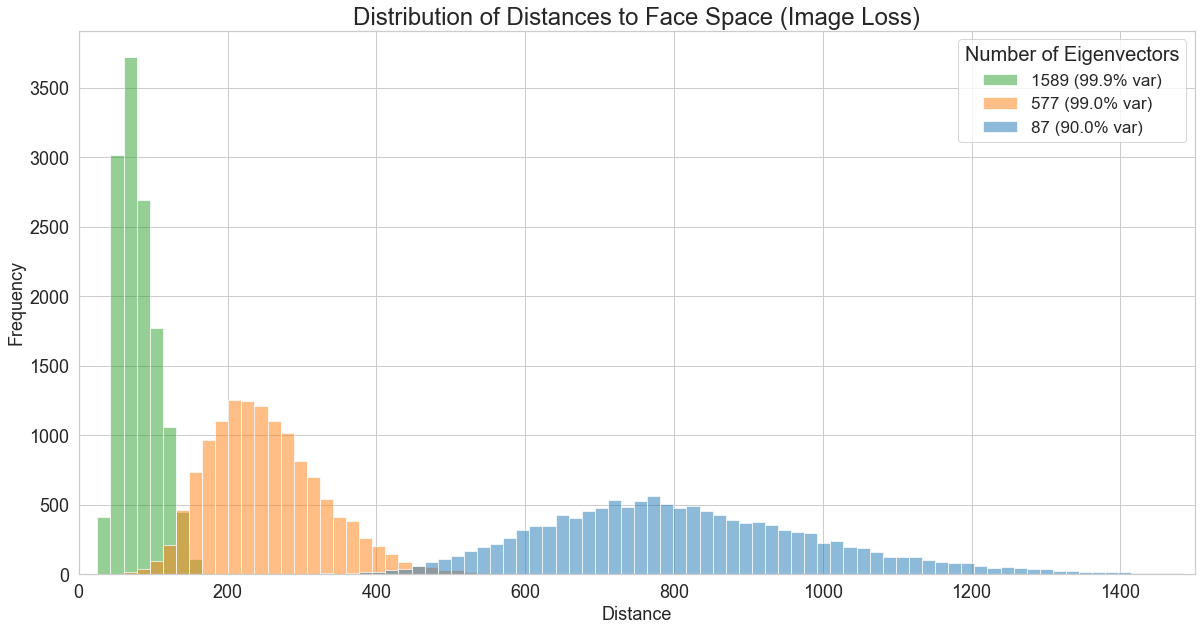

In [8]:
distances = pd.DataFrame({"distances": pd.concat([distances_table.iloc[: , 0], 
                                                        distances_table.iloc[: , 1], 
                                                        distances_table.iloc[: , 2]]),
                               "eigenvectors": pd.concat([pd.Series([distances_table.columns[0]] * len(X)),
                                                          pd.Series([distances_table.columns[1]] * len(X)),
                                                          pd.Series([distances_table.columns[2]] * len(X))])
                         })

plt.figure(figsize=(20,10))

histograms = sns.histplot(data=distances, x="distances", hue="eigenvectors", palette="tab10", bins=150)

plt.title("Distribution of Distances to Face Space (Image Loss)", size=24)
plt.xlabel("Distance", size = 18)
plt.ylabel("Frequency", size = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlim([0, 1500])

plt.legend(distances_table.columns.tolist()[::-1], fontsize = 17, title="Number of Eigenvectors", title_fontsize = 20)

In the plot above, you can see the distributions of distances from a vector in ${\rm I\!R}^{4096}$ to its projection in ${\rm I\!R}^{k}$, where $k$ is the number of eigenvectors used to span the subspace of ${\rm I\!R}^{4096}$.  This subspace is sometimes refered to as the **face space**.  You'll notice that as the number of dimensions of the face space increase, the distribution of distances becomes more centered, and is comprised of smaller distances.  In other words, more eigenvectors minimize the distance between the original observations and their projections.

In [9]:
prop_vars = [0.9, 0.99, 0.999, 1.0]

for prop_var in prop_vars:
    ef._set_basis(prop_var_retained = prop_var)
    
    ef.save_reduced_dataset(X, replace=False)

In [10]:
file_sizes = pd.DataFrame()

folders = os.listdir("./reduced_datasets")

for folder in folders:
    eigenface_size = os.path.getsize("./reduced_datasets/" + folder + "/eigenfaces.csv")
    projections_size = os.path.getsize("./reduced_datasets/" + folder + "/projections.csv")
    
    file_sizes = file_sizes.append({'Eigenfaces Size (MB)' : eigenface_size, 'Projections Size (MB)' : projections_size},  
                ignore_index = True) 

dir = "./datasets/lfwcrop_grey/faces"
file_names = os.listdir(dir)
paths = [dir + "/" + file_name for file_name in file_names]
sizes = [os.path.getsize(path) for path in paths]
original_size = sum(sizes)

file_sizes = file_sizes.append({'Eigenfaces Size (MB)' : 0, 'Projections Size (MB)' : original_size},  
                ignore_index = True) 
                
folders.append("original ")
file_sizes['Eigenfaces'] = [folder_name[0:folder_name.find('_')] for folder_name in folders]
file_sizes.set_index('Eigenfaces', inplace=True)

file_sizes["Total (MB)"] = file_sizes.sum(axis=1)

file_sizes = round(file_sizes / 1000000,3)

file_sizes = file_sizes.reindex(['87', '577', '1589', '4096', 'original'])

file_sizes

,Eigenfaces Size (MB),Projections Size (MB),Total (MB)
Eigenfaces,,,
87,7.652,21.720,29.371
577,50.727,144.433,195.161
1589,139.675,398.996,538.671
4096,360.140,1050.337,1410.478
original,0.000,54.374,54.374


The table above shows the file sizes of `.csv` files used to store the eigenfaces and the projections of reduced datasets. Using all eigenfaces (4096) results in a total of 1410.478 MB, but by only using the first 1589 eigenfaces, we can reduce that by 2.618x to 538.671 MB and still retain 99.9% variance in the reconstructed images.  If the system administrator is willing to accept further loss of image quality, these file sizes can be reduced to 195.161 MB and 29.371 MB.

The first 4 rows describe the file size when using `.csv` files, wheras the `original` row describes the collection of `.pgm` files in the original dataset.  The original dataset has the smallest total file size of all the methods presented, which demonstrates that while eigenfaces can be used for data reduction, there are more modern methods that work better.

# Machine Learning Application

This method has been shown to be an early method of facial recognition in the field of machine learning.  By using PCA as a dimension reduction tool, machine learning models can isolate the features that explain the variance between images, and recognize when images are similar.

Turk and Pentland describe four different types of points in ${\rm I\!R}^{N^2}$ that can be identified.  Recall that the face spacce, ${\rm I\!R}^{k}$, is a subspace of ${\rm I\!R}^{N^2}$: ${\rm I\!R}^{k}\subseteq {\rm I\!R}^{N^2}$.  The descriptions below and image provided (created by Turk and Pentland) describe a facial recognition model.

1. Points that are close to the face space and whose projection is close to known face vectors.  These points should be identified as the nearest known faces, and should be recognized by the system.  These points are **true positives**.

2. Points that are close to the face space but whose projection is far away from known face vectors.  In this case, the system has identified a face, but it is unknown.  The system can either deny the user access, or enroll the user into the system to be recognized in future.

3. Points that are far away from the face space, but whose projection is close to known face vectors in the face space.  These points are likely not faces because of their distance to the face space.  However, their projection will likely be classified as a known face.  These points are **false positives**.

4. Points that are far away from the face space, and whose projection is far away from known face vectors in the face space.  These points are likey images of other objects besides faces.



<img src="./images/turk_pentland_projection.PNG" alt="turk_pentland_projection" width="50%" height="50%" align="center">

Described here, is a more robust system of the K Nearest Neighbors (KNN) classifier, which is used in many different machine learning applications **[[1]](#sources)**.

Yambor et al. describe more specific methods of tuning this KNN classifier when using eigenfaces.  They experiment with different distance metrics (inner products), selection of eigenfaces for a basis, and lighting changes.  Their results show that for large numbers of images, the Mahalanobis distance metric performs better than the Euclidean distance metric.  They also show that it is possible to remove the first couple of eigenfaces to remove lighting information.  Finally, they confirm, as expected, that recognition rates are higher for larger face spaces **[[6]](#sources)**.

This technique was an early method for facial recognition, but has now been surpassed by more modern approaches, such as deep learning.  When constructing a facial recognition system, this method is not recommended.

# Conclusion

## Extensions

This method could be extended in many different ways.  For example, the first choice is to use this method on higher resolution images.  This would work because of our efficient computation of the eigenvectors of the covariance matrix.  This method could also be used on other objects that contain predictable features, such as animals, flowers, and possibly cars.

Another extension is to bring this problem into the field of multi-linear algebra.  By using tensors and other objects from that field, its possible to perform this decomposition for color images (a basis for each color channel), as well as perform this method without having to flatten images.  

## Closing Remarks

In this project, Eigenface decomposition was performed, as well as an analysis of its data reduction power and a discussion of its application in facial recognition.  While there has been significant development in both data reduction and facial recognition, leaving this method out-performed, this method is an interesting way to apply knowledge from linear algebra, statistics, and computer science.  If anything, this method shows creativity paired with quantitative skill, which is something needed in data science methods.  I had a lot of fun working on this project, and I'm glad to be able to share it with you!  


## Acknowledgements
I'd like to thank Mark Shoemaker for being a great teacher of Linear Algebra II (MATH 469) during an online semester.  He is very knowledgeable and has done a great job of interacting with his students.  I had a great semester with him!  I'd also like to thank Tianjian Zhou for introducing me to Principal Component Analysis, and helping me build a solid foundation of understanding for this project.

# Sources

<a id='sources'></a>

[1] Turk, M.A., and A.P. Pentland. “Face Recognition Using Eigenfaces.” Proceedings. 1991 IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 1991, doi:10.1109/cvpr.1991.139758. 

[2] Zhou, Tianjian. “Lecture 9 Principal Component Analysis.” STAT 460 - Applied Multivariate Analysis. STAT 460 - Applied Multivariate Analysis, 9 Mar. 2021, Fort Collins, CO, Colorado State University. 

[3] Li, Casey Juanxi. “PCA, Visualized for Human Beings.” Medium, Medium, 2 Aug. 2020, [medium.com/@sometimescasey/pca-visualized-for-human-beings-47d19a122734. ](https://medium.com/@sometimescasey/pca-visualized-for-human-beings-47d19a122734)

[4] Zabarauskas, Manfredas. “Eigenfaces Tutorial.” Manfred Zabarauskas' Blog, 2 Oct. 2009, [blog.manfredas.com/eigenfaces-tutorial/.](http://blog.manfredas.com/eigenfaces-tutorial/) 

[5] C. Sanderson, B.C. Lovell.
    Multi-Region Probabilistic Histograms for Robust and Scalable Identity Inference.
    ICB 2009, LNCS 5558, pp. 199-208, 2009.

[6] Yambor, Wendy S., et al. “Analyzing PCA-Based Face Recognition Algorithms: Eigenvector Selection and Distance Measures.” Series in Machine Perception and Artificial Intelligence, 2002, pp. 39–60., doi:10.1142/9789812777423_0003. 

[7] Acar, Nev. “Eigenfaces: Recovering Humans from Ghosts.” Medium, Towards Data Science, 2 Sept. 2018, [towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184.](https://towardsdatascience.com/eigenfaces-recovering-humans-from-ghosts-17606c328184)